# Atomistic Strain Calculation Tool

This notebook illustrates the procedure that is used to calculate the atomistic strain from a LAMMPS trajectory. 

## Imported Codes 

Much of the functionality is included in the imported files *lammpsreader.py*, *auxil.py*, *neicelllist.py* and *agg3dm.py*. 

+ **lammpsreader.py** : Includes code that reads and parses LAMMPS text trajectory files. We get the atom coordinates of a trajectory frame using this code.  
+ **auxil.py** : Mostly includes code that handles the calculation of distances using the periodic boundary condition. 
+ **neicelllist.py** : Includes code that speeds up the calculation of neighbor atoms surrounding a central atom. Necessary for systems with a large number of atoms.
+ **agg3dm.py** : Includes code that spatially averages the calculated strain in cubix boxes in the simulation domain. The average strain per box can then be plotted using a heatmap. 

## Starting Up

First we start by importing most necessary libraries and setting up a few input variables. We must specify the trajectory filename, the frame (timestep) that is considered to be the origin of the deformation, the timestep that is the final stage of the deformation and the cutoff distance used when searching for neighbors of a central atom. 


In [2]:
%matplotlib inline
import time
from auxil import *
from lammpsreader import LammpsTrajReader, isLammpsDataSorted, sortLammpsData
from neicelllist import NeiCellList

trajectory_filename = 'trajectory.lammpstrj'
start_frame = 0
end_frame = 250
rcut = 10.0

## Reading the atomistic positions

We use a *LammpsTrajReader* to read the atomistic trajectory. We use the *seek_to_trajectory_step* (defined in *auxil.py*) to seek to the starting and the ending frame of the deformation. We get the coordinates and the box sizes from these two frames, which is the input of the strain calculation code we will use later.  

In [4]:
reader = LammpsTrajReader(trajectory_filename)
print("Loading starting frame")
start_conf = seek_to_trajectory_step(reader, start_frame)
if start_conf is None:
    raise Exception('conf not found')
if not isLammpsDataSorted(start_conf):
    print('Sorting frame')
    sortLammpsData(start_conf)

prevCoords = pick_conf_coords(start_conf)
prevBoxOffset = calc_box_offset(start_conf)
prevBoxSize = calc_box_size(start_conf)

end_conf = seek_to_trajectory_step(reader, end_frame)
if end_conf is None:
    raise Exception('conf not found')
if not isLammpsDataSorted(end_conf):
    print('Sorting frame')    
    sortLammpsData(end_conf)

newCoords = pick_conf_coords(end_conf)
newBoxSize = calc_box_size(end_conf)

Loading starting frame
Seeking to trajectory step 0
Read conf 0
Seeking to trajectory step 250
Read conf 50
Read conf 100
Read conf 150
Read conf 200
Read conf 250


## Calculating the neighbor displacements

We defined *calc_dxs*, a function that calculates the 3d displacements of an atom's neighbors. It takes as input the index of the atom and of its neighbours, as well as the coordinates of all the atoms in the current frame. It returns a matrix of shape (3,*number_of_neighbors*).

In [5]:
def calc_dxs(atm, neins, coords, box_size):
    x = coords['x']
    y = coords['y']
    z = coords['z']
    posm = np.array([x[atm], y[atm], z[atm]])
    result = np.zeros((3,len(neins)))
    i = 0
    for nein in neins:
        posn = np.array([x[nein], y[nein], z[nein]])
        dx = periodicDistanceVec(posn,posm,box_size)
        result[:,i] = dx
        i += 1
    return result

## Defining the objective function

We define the objective function the needs to be minimized. It takes as input the deformation gradient *F* and the neighbor displacements at the initial and the final frame of the deformation. It returns as output the scalar squared error *W*. Note that we use the Numba library in order to speed up our code.

In [6]:
from numba import njit

@njit()
def obj_func(f,DXS,dxs):
    W = 0.0
    for i in range(dxs.shape[1]):
        dx0 = dxs[0,i]
        dx1 = dxs[1,i]
        dx2 = dxs[2,i]
        DX0 = DXS[0,i]
        DX1 = DXS[1,i]
        DX2 = DXS[2,i]
        tmp0 = dx0 - f[0]*DX0 - f[1]*DX1 - f[2]*DX2
        tmp1 = dx1 - f[3]*DX0 - f[4]*DX1 - f[5]*DX2
        tmp2 = dx2 - f[6]*DX0 - f[7]*DX1 - f[8]*DX2
        W += (tmp0*tmp0 + tmp1*tmp1 + tmp2*tmp2)
    return W

## Creating the neigbor cell list

The *NeiCellList* is a class that takes as input the coordinates of all the atoms in a frame and indexes them spatially into rectangular cuboids. This allows fast neighbor searching within a cutoff disrtance *rcut*. The *make_nei_cell_list* function below first creates the cuboids using *makeCells* and then places the atoms in the cells with *makeList*. 

In [7]:
def make_nei_cell_list(xs,ys,zs,box_size,rcut):
    ncl = NeiCellList()
    ncl.makeCells(box_size[0], box_size[1], box_size[2], rcut)
    ncl.makeList(xs,ys,zs)
    return ncl

## The actual calculation performing routine

The *calc_strain* function performs the actual calculations. It takes as input the coordinates of the starting and ending frames, as well as the cutoff distance used to select neighbors. For earch atom in the system it minimizes the objective function by solving for a zero jacobian and thus acquires an optimal deformation gradient *f0*. It then calculates the strain tensor *e* corresponding to this deformation gradient. It return the strain tensors for all the atoms in the system in a array with shape *(number_of_atoms,3,3)*. Some auxiliary code in this function prints out the progress of the calculations every once in a while.

In [8]:
def calc_strain(prevCoords, prevBoxOffest, prevBoxSize, newCoords, newBoxSize, rcut):
    print('Calculating strain...')
    prevProgressStr = ''
    startTime = time.time()

    x = prevCoords['x'] - prevBoxOffest[0]
    y = prevCoords['y'] - prevBoxOffest[1]
    z = prevCoords['z'] - prevBoxOffest[2]
    atCount = len(x)
    strains = np.zeros((atCount,3,3), dtype=np.float64)
    ncl = make_nei_cell_list(x,y,z,prevBoxSize,rcut)

    for atm in range(atCount):
        neis = ncl.calcNeisOf(atm,x,y,z,rcut)
        DXS = calc_dxs(atm, neis, prevCoords, prevBoxSize)
        dxs = calc_dxs(atm, neis, newCoords, newBoxSize)
        f0 = np.linalg.solve(np.kron(DXS@DXS.T,np.eye(3)),(dxs@DXS.T).flatten()).reshape(3,3)
        # res0 = obj_func(f0.flatten(),DXS,dxs)
        e = 0.5 * (np.matmul(f0.transpose(),f0) - np.identity(3))
        strains[atm,:,:] = e
        
        if atm % 500 == 0:
            percentDone = float(atm)/float(atCount) * 100.0
            progressStr = '%.1f%%' % percentDone
            if progressStr != prevProgressStr:
                if percentDone > 0.0:
                    timeElapsed = time.time() - startTime
                    timeRemaining = timeElapsed * (100.0 / percentDone - 1.0)
                    print('Done', progressStr, 'time remaining is', time_length_str(timeRemaining))
                    prevProgressStr = progressStr
    
    return strains

## Running the calculation

We run the strain calculation for the sample system of this notebook. It should take about a minute to complete. Watch the progress as it is printed. The total time of the calculation is printed at the end. 

In [11]:
startTime = time.time()

strain_data = calc_strain(prevCoords, prevBoxOffset, prevBoxSize, newCoords, newBoxSize, rcut)

timeElapsed = time.time() - startTime
print('Calculation completed in', time_length_str(timeElapsed))

Calculating strain...
Done 4.1% time remaining is 00:00:49
Done 8.2% time remaining is 00:00:46
Done 12.2% time remaining is 00:00:47
Done 16.3% time remaining is 00:00:44
Done 20.4% time remaining is 00:00:41
Done 24.5% time remaining is 00:00:38
Done 28.5% time remaining is 00:00:34
Done 32.6% time remaining is 00:00:31
Done 36.7% time remaining is 00:00:28
Done 40.8% time remaining is 00:00:26
Done 44.8% time remaining is 00:00:23
Done 48.9% time remaining is 00:00:21
Done 53.0% time remaining is 00:00:19
Done 57.1% time remaining is 00:00:18
Done 61.1% time remaining is 00:00:16
Done 65.2% time remaining is 00:00:14
Done 69.3% time remaining is 00:00:12
Done 73.4% time remaining is 00:00:11
Done 77.4% time remaining is 00:00:09
Done 81.5% time remaining is 00:00:07
Done 85.6% time remaining is 00:00:05
Done 89.7% time remaining is 00:00:04
Done 93.7% time remaining is 00:00:02
Done 97.8% time remaining is 00:00:00
Calculation completed in 00:00:41


## Visualizing the results

We will visualize the local strain per atom by spatially aggregating the results into cubic boxes of some specified size, which is 6 Angstroms in the present example. We will visualize the xx part of the strain tensor, which corresponds to row 0 and column 0. 

In [12]:
from agg3dm import Aggregator3DM
import matplotlib.pyplot as plt
import seaborn as sns

plot_aggsize = 6.0
plot_row = 0
plot_col = 0

The *add* method of the *Aggregator3DM* class accumulates the strain of a specified atom at its corresponging box. The *calc_averages_by_count* method averages the sums by the atom count in each box. A heatmap plot is created with the results and is shown below. The x axis is the axis of deformarion, while the intersection chosen at the z axis is at the middle of the box. Note that the silica nanoparticle is placed at the center of the box. So what we see below is an intersection passing through the center of the nanoparticle. The strain in the nanoparticle is almost zero, while just outside of it, at the x direction, it is much higher than in the bulk area. 

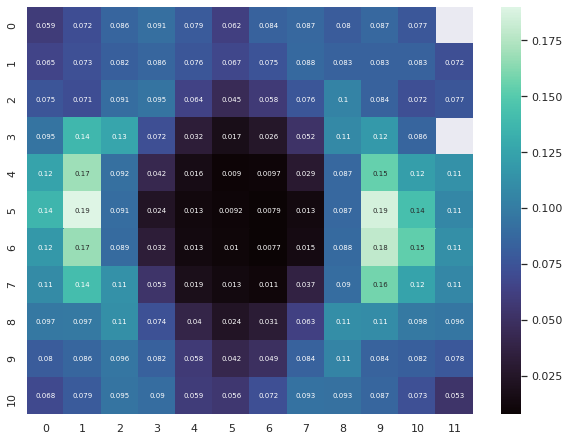

In [14]:
box_params = calc_box_params(end_conf)
xlo = box_params[0,0]
xhi = box_params[0,1]
ylo = box_params[1,0]
yhi = box_params[1,1]
zlo = box_params[2,0]
zhi = box_params[2,1]

xs = end_conf['x']
ys = end_conf['y']
zs = end_conf['z']
nats = len(xs)

agg = Aggregator3DM(xlo,xhi,ylo,yhi,zlo,zhi, plot_aggsize, (3,3))

for iat in range(nats):
    p = np.array([xs[iat], ys[iat], zs[iat]])
    s = strain_data[iat,:,:]
    agg.add(p,s)

averages = agg.calc_averages_by_count()
nx = averages.shape[0]
ny = averages.shape[1]
nz = averages.shape[2]
iz = int(nz//2)
plot_data = np.zeros((ny,nx))
for ix in range(nx):
    for iy in range(ny):
        plot_data[ny-iy-1,ix] = averages[ix,iy,iz,plot_row,plot_col]

fig = plt.figure(figsize=(10,7.5))
sns.set_theme()
ax = sns.heatmap(plot_data, annot=True, cmap="mako", annot_kws={"fontsize":7})